In [15]:
import numpy as np
import os
import string
import matplotlib.pyplot as plt
import torch
np.set_printoptions(precision=3)

# Naive Bayes (Problem 3)

In [16]:
file_count = len(os.listdir("data/languageID/train"))
s_count = 0
j_count = 0
e_count = 0
for name in os.listdir("data/languageID/train"):
    if name.startswith("e"):
        e_count +=1
    elif name.startswith("j"):
        j_count +=1
    else:
        s_count += 1
        

phi_s = np.log((s_count + 0.5)/(file_count + 3/2))
phi_j = np.log((j_count + 0.5)/(file_count + 3/2))
phi_e = np.log((e_count + 0.5)/(file_count + 3/2))

priors = {"s": phi_s, "j": phi_j, "e": phi_e}

print("p(y = s): {}".format(np.exp(phi_s)))
print("p(y = j): {}".format(np.exp(phi_j)))
print("p(y = e): {}".format(np.exp(phi_e)))

p(y = s): 0.3333333333333333
p(y = j): 0.3333333333333333
p(y = e): 0.3333333333333333


In [17]:
chars = list(string.ascii_lowercase) + [" "]

# row 0 has s, row 1
char_counts = {l: np.zeros(27, dtype=int) for l in ["s", "j", "e"]}

s_char_count = 0
j_char_count = 0
e_char_count = 0

for name in os.listdir("data/languageID/train"):
    with open("data/languageID/train/" + name, 'r') as f:
        word = ' '.join(f.read().split())
        #print(word.strip())
        lang = name[0]
        for i in range(len(word)):
            if word[i] == " ":
                ind = 26
            else:
                ind = string.ascii_lowercase.index(word[i])
            char_counts[lang][ind] += 1
            
    f.close()
    

for l in ["s", "j", "e"]:
    char_counts[l] = (char_counts[l] + 0.5)/(np.sum(char_counts[l]) + 27/2)
    print(l)
    print([float('{:.3f}'.format(x)) for x in char_counts[l]])
    char_counts[l] = np.log(char_counts[l])


s
[0.105, 0.008, 0.038, 0.04, 0.114, 0.009, 0.007, 0.005, 0.05, 0.007, 0.0, 0.053, 0.026, 0.054, 0.073, 0.024, 0.008, 0.059, 0.066, 0.036, 0.034, 0.006, 0.0, 0.002, 0.008, 0.003, 0.168]
j
[0.131, 0.011, 0.005, 0.017, 0.06, 0.004, 0.014, 0.032, 0.097, 0.002, 0.057, 0.001, 0.04, 0.056, 0.091, 0.001, 0.0, 0.043, 0.042, 0.057, 0.07, 0.0, 0.02, 0.0, 0.014, 0.008, 0.127]
e
[0.06, 0.011, 0.022, 0.022, 0.105, 0.019, 0.017, 0.047, 0.055, 0.001, 0.004, 0.029, 0.021, 0.058, 0.064, 0.017, 0.001, 0.054, 0.066, 0.08, 0.027, 0.009, 0.015, 0.001, 0.014, 0.001, 0.179]


In [18]:
e10_counts = np.zeros(27, dtype=int)
with open('data/languageID/test/e10.txt', 'r') as f:
    word = ' '.join(f.read().split())
    for i in range(len(word)):
        if word[i] == " ":
            ind = 26
        else:
            ind = string.ascii_lowercase.index(word[i])
        e10_counts[ind] += 1
        
print(e10_counts.tolist())

[164, 32, 53, 57, 311, 55, 51, 140, 140, 3, 6, 85, 64, 139, 182, 53, 3, 141, 186, 225, 65, 31, 47, 4, 38, 2, 491]


In [19]:
e10_likelihood = {}
for l in ['e', 'j', 's']:
    e10_likelihood[l] = np.dot(e10_counts, char_counts[l])
    print("log(p(x| y = {})): {}".format(l, e10_likelihood[l]))
    
    

log(p(x| y = e)): -7829.840680454434
log(p(x| y = j)): -8752.354173310623
log(p(x| y = s)): -8454.863043293946


In [20]:
for l in ['e', 'j', 's']:
    posterior = priors[l] + e10_likelihood[l]
    print("p(y = {}| x): {}".format(l, posterior))

p(y = e| x): -7830.939292743102
p(y = j| x): -8753.452785599291
p(y = s| x): -8455.961655582614


In [21]:
def predict(f):
    letter_counts = np.zeros(27, dtype=int)
    word = ' '.join(f.read().split())
    for i in range(len(word)):
        if word[i] == " ":
            ind = 26
        else:
            ind = string.ascii_lowercase.index(word[i])
        letter_counts[ind] += 1
    
    posteriors = {}
    for l in ['e', 'j', 's']:
        posteriors[l] = priors[l] + np.dot(letter_counts, char_counts[l])
        
    v = list(posteriors.values())
    k = list(posteriors.keys())
    return k[v.index(max(v))]

In [25]:
conf_mat = np.zeros((3, 3), dtype=int)
langs= {'e': 0, 'j': 1, 's': 2}

for name in os.listdir("data/languageID/test"):
    true_label = name[0]
    with open("data/languageID/test/" + name, 'r') as f:
        pred_label = predict(f)
        i, j = langs[pred_label], langs[true_label]
        conf_mat[i, j] += 1
print(conf_mat)

[[10  0  0]
 [ 0 10  0]
 [ 0  0 10]]


## Neural Network (Problem 4)

In [27]:
def get_curve_data():
    folder_path = 'src/curve'
    filenames = [name for name in os.listdir(folder_path)]
    paths = [os.path.join(folder_path, name) for name in filenames]
    models = [name.split('-')[0] for name in filenames]
    lrs = [float(name.split('-')[1][3:]) for name in filenames]
    inits = [name.split('-')[2][5:] for name in filenames]
    return [{'model': mod, 'lr': lr, 'init': init, 'curve': torch.load(fp)} for mod, lr, init, fp in zip(models, lrs, inits, paths)]

In [28]:
def plot(lr=1e-1, curve_type='train_err', model=None, init=['uniform']):
    curves = get_curve_data()
    fig = plt.figure()
    for curve in curves:
        if curve['lr'] == lr and curve['init'] in init:
            if model is not None:
                if curve['model'] == model:
                    plt.plot(curve['curve'][curve_type], label=curve['init'] + " initialization", marker='o', markevery=5)
            else:
                plt.plot(curve['curve'][curve_type], label=curve['model'] + " initialization", marker='o', markevery=5)
    plt.grid()
    title = "{} Error on MNIST".format(curve_type.split('_')[0].capitalize())
    plt.title(title)
    plt.ylim(0, 0.2)
    plt.xlabel("Epoch")
    plt.ylabel("Error")
    if len(init) > 1:
        plt.legend()
    return fig

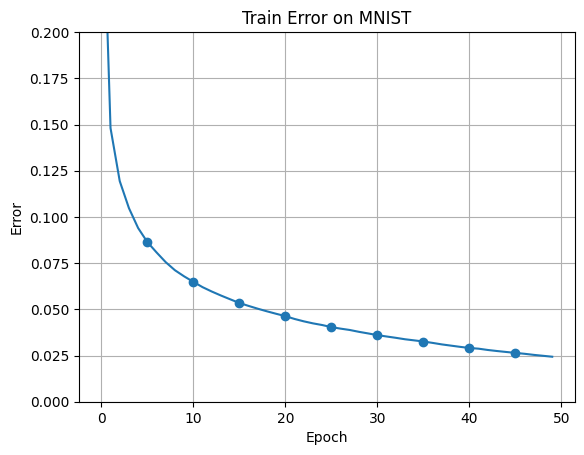

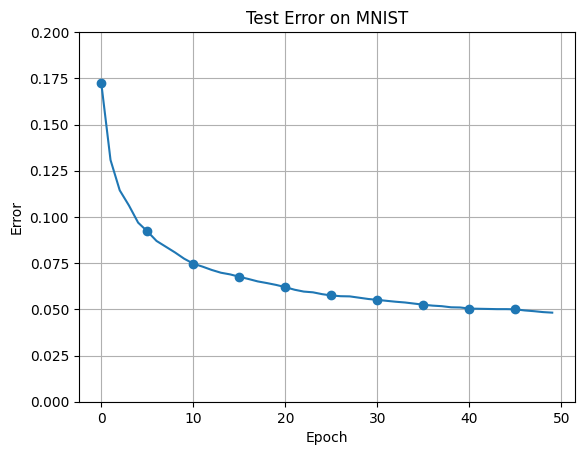

In [35]:
os.makedirs('fig', exist_ok=True)

fig1 = plot(lr=1e-1, curve_type='train_err', model='scratch', init=['uniform'])
name1 = "scratch_train"
plt.savefig(os.path.join('fig', name1))
fig2 = plot(lr=1e-1, curve_type='test_err', model='scratch', init=['uniform'])
name2 = "scratch_test"
plt.savefig(os.path.join('fig', name2))

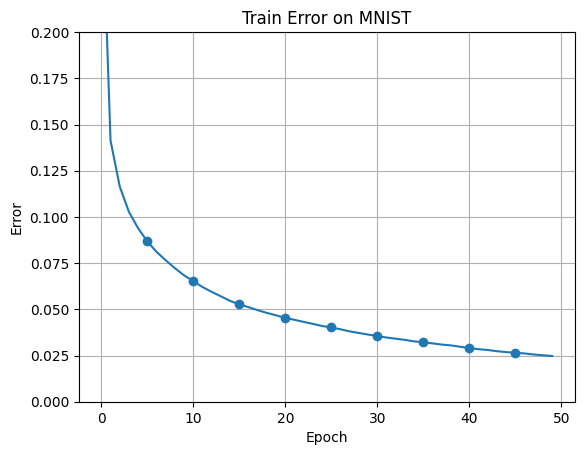

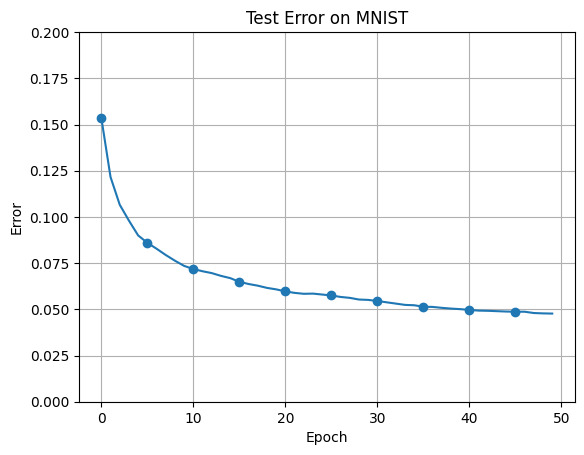

In [36]:
fig = plot(lr=1e-1, curve_type='train_err', model='torch', init=['uniform'])
plt.savefig(os.path.join('fig', 'torch_train'))
fig = plot(lr=1e-1, curve_type='test_err', model='torch', init=['uniform'])
plt.savefig(os.path.join('fig', 'torch_test'))

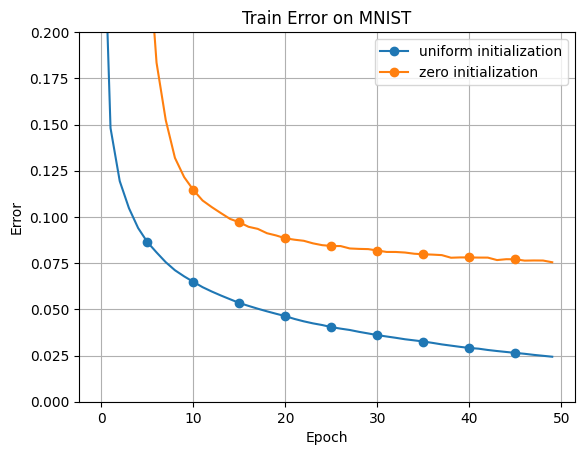

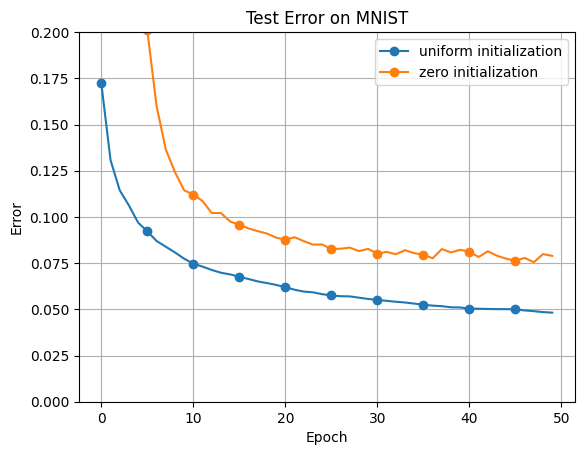

In [37]:
fig = plot(lr=1e-1, curve_type='train_err', model='scratch', init=['uniform', 'zero'])
plt.savefig(os.path.join('fig', 'scratch_compare_train'))
fig = plot(lr=1e-1, curve_type='test_err', model='scratch', init=['uniform', 'zero'])
plt.savefig(os.path.join('fig', 'scratch_compare_test'))